-Constraint to set one node to 1 for the ending node: $(1-\sum_i y_i + \sum_{i\neq j} 2y_iy_j)$

-Constraint to set other nodes to 0 or 2: $(\sum_jy_j)(2-\sum_jy_j)^2= \sum_i y_i-2\sum_{i\neq j}y_iy_j+2\sum_{i\neq j,i\neq k,j\neq j}y_iy_jy_k$. Adding ancilla variables to make it QUBO:
$\sum_i y_i-2\sum_{i\neq j}y_iy_j+2\sum_{i\neq j,i\neq k,j\neq k}[w_{i,j}y_k]+\sum_{i\neq j,i\neq k,j\neq k}[y_iy_j-2w_{i,j}(y_i+y_j)+3w_{i,j}]$

-Constraint to set one node to $n$ for the starting node: $(\sum_iy_i-n)^2=n^2-(2n-1)\sum_i y_i+\sum_{i\neq j} 2y_iy_j$

-Minimum distance objective function:  $w\sum_{i \notin start, i \notin start} y_i$ if $w$ is not there 0 would be a viable solution too. While the constraints only add a penalty or reward of 1/-1, the objective function's penalty grows linearly with the routs length. Therefore, it is imperetive that we nulify the effect of this growth with a small weight. A weight too big wont do shit and a weight too small will make the adiabatic gap very tiny and inceases the error rate. 

In [1]:
#import the necessary shit
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from itertools import combinations_with_replacement as cwr

import dwave_networkx as dnx
import networkx as nx
import minorminer
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import FixedEmbeddingComposite

%matplotlib inline

/home/sarashs/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


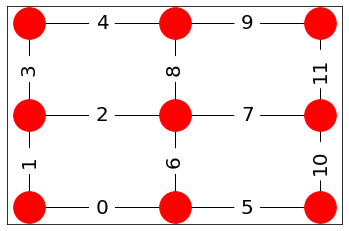

In [2]:
G=nx.grid_2d_graph(3,3)
pos = dict( (n, n) for n in G.nodes() )
l=0
labels={}
for i in G.edges:
    labels[i]=l
    l+=1
nx.draw_networkx_nodes(G,pos,node_size=1000,node_color='r')
nx.draw_networkx_edges(G,pos)
nx.draw_networkx_edge_labels(G,pos,labels,font_size=20)
plt.show()

In [161]:
#prepare the netlist

net_start=[(0,1)]
net_end=[(2,1)]
n=len(net_end)

In [203]:
Q={}
H={}
J={}
for i,j in cwr(list(labels.values()),2):
    if i==j:
        Q[(f'y{i}',f'y{j}')]=0
        H[f'y{i}']=0
    else:
        J[(f'y{i}',f'y{j}')]=0
Starting_node=[]
end_nodes={}
other_nodes={}
for item_1 in net_end:
    end_nodes[item_1]=[]
for item_1 in G.nodes:
    if item_1 not in net_end and item_1 not in net_start:
        other_nodes[item_1]=[]

# iterate over numerical edge labels
for edge_pair, num_lab in labels.items():
    # objective
    w1=1
    Q[(f'y{num_lab}',f'y{num_lab}')]=1*w1
    H[f'y{num_lab}']=1*w1
    # According to Arash, VPR defines nets as having one start and multiple ends
    #Starting node
    if edge_pair[0] in net_start or edge_pair[1] in net_start:
        Starting_node.append(num_lab)
    #end node
    if edge_pair[0] in net_end:
        end_nodes[edge_pair[0]].append(num_lab)
    if edge_pair[1] in net_end:
        end_nodes[edge_pair[1]].append(num_lab)
    #other nodes
    if edge_pair[0] in other_nodes:
        other_nodes[edge_pair[0]].append(num_lab)
    if edge_pair[1] in other_nodes:
        other_nodes[edge_pair[1]].append(num_lab)   

#constraint on end nodes
w2=1
# each item is a list of (numerical) edge labels ending in the node
for node, num_lab_list in end_nodes.items():
    # for each pair of edges
    for i,j in cwr(num_lab_list,2):
        if i==j:
            #######Removing end node edges from the objective
            Q[(f'y{i}',f'y{j}')]+=-1*w1 
            H[f'y{i}']+=-1*w1
            ##############################
            Q[(f'y{i}',f'y{j}')]+=-1*w2
            H[f'y{i}']+=-1*w2
        else:
            J[(f'y{i}',f'y{j}')]+=2*w2

#constraint on other nodes
w3=1
# yiyj and weightm
w_and=1

# iterate over numerical edge labels
for node, num_lab_list in other_nodes.items():
    for i,j in cwr(num_lab_list,2):
        if i==j:
            Q[(f'y{i}',f'y{j}')]+=w3
            H[f'y{i}']+=w3
        else:
            J[(f'y{i}',f'y{j}')]+=-2*w3
    for i,j,k in cwr(num_lab_list,3):
        if i !=j and j!=k and i !=k:
            if (f'w{i}{j}',f'y{k}') not in Q:
                J[(f'w{i}{j}',f'y{k}')]=0
            J[(f'w{i}{j}',f'y{k}')]+=2
            J[(f'y{i}',f'y{j}')]+=2*w_and
            if (f'w{i}{j}',f'y{i}') not in Q:
                J[(f'w{i}{j}',f'y{i}')]=0
            J[(f'w{i}{j}',f'y{i}')]+=-2*w_and
            if (f'w{i}{j}',f'y{j}') not in Q:
                J[(f'w{i}{j}',f'y{j}')]=0
            J[(f'w{i}{j}',f'y{j}')]+=-2*w_and
            if (f'w{i}{j}',f'w{i}{j}') not in Q:
                Q[(f'w{i}{j}',f'w{i}{j}')]=0
                H[f'w{i}{j}']=0
            Q[(f'w{i}{j}',f'w{i}{j}')]+=3*w_and
            H[f'w{i}{j}']+=3*w_and
#constraint on the starting node
w4=1
# Starting_node is a list of numerical labels and not a dict
for i,j in cwr(Starting_node,2):
    if i==j:
        #######Removing starting node edges from the objective
        H[f'y{i}']+=-1*w1 
        Q[(f'y{i}',f'y{j}')]+=-1*w1 
        ##############################
        H[f'y{i}']+=-(2*n-1)*w4
        Q[(f'y{i}',f'y{j}')]+=-(2*n-1)*w4
    else:
        J[(f'y{i}',f'y{j}')]+=2*w4
Q.update(J)

In [204]:
%%time

def longest_chain_in_embed(e):
    return np.max([len(i) for i in e.values()])

def find_embedding(Q, A, num_tries=100):
    best_embedding = None
    best_chain_len = np.inf

    for i in range(num_tries):
        e = minorminer.find_embedding(Q, A)
        if len(e)>0:
            chain_len = longest_chain_in_embed(e)
            if chain_len < best_chain_len:
                best_embedding = e
                best_chain_len = chain_len

    return best_embedding, best_chain_len    


dwave_sampler = DWaveSampler(solver={'lower_noise': True, 'qpu': True})
A = dwave_sampler.edgelist
embedding, chain_len = find_embedding(Q, A)
# the shortest chain_len I've seen with num_tries=1000 is 5
# (SP: takes 2.5 mins on my machine)
display(chain_len)

5

CPU times: user 22 s, sys: 68.1 ms, total: 22.1 s
Wall time: 23 s


/home/sarashs/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/sarashs/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/home/sarashs/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


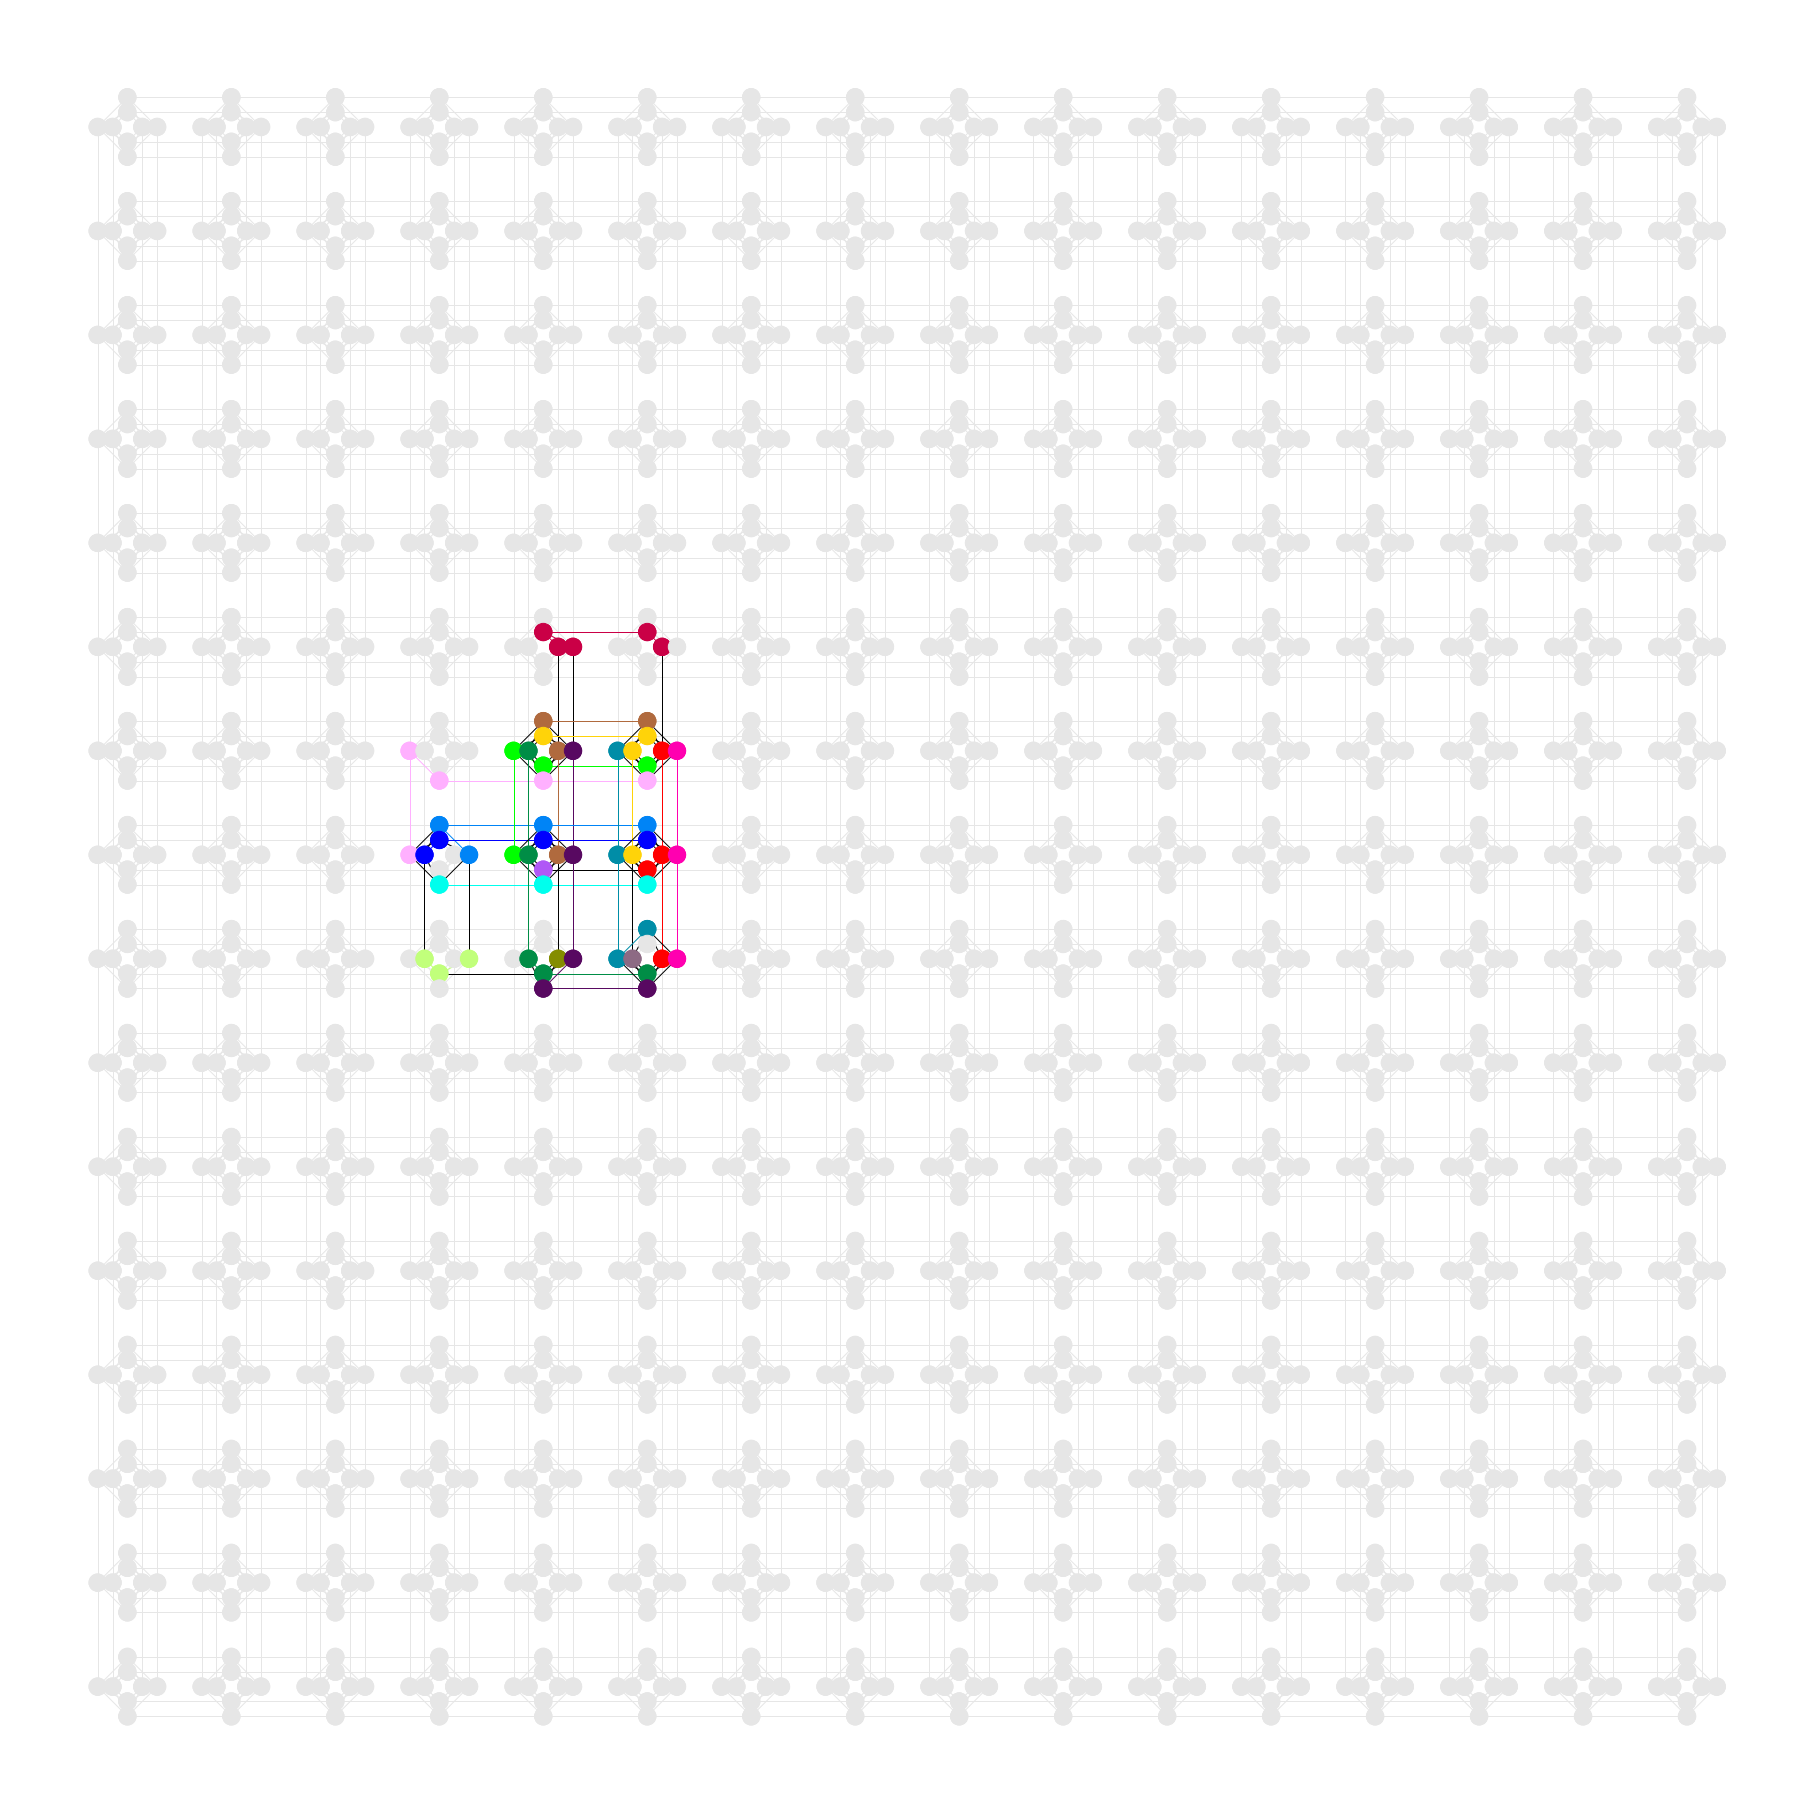

In [205]:
connectivity_structure = dnx.chimera_graph(16,16)
fig=plt.figure(figsize=(25, 25))
dnx.draw_chimera_embedding(connectivity_structure, embedding)

In [206]:
#set up the Qubo
sampler = FixedEmbeddingComposite(DWaveSampler(solver={'lower_noise': True, 'qpu': True}),embedding)
response=sampler.sample_qubo(Q, chain_strength=4,annealing_time=500, auto_scale=True, num_reads=1000) #

In [207]:
response_num=0
l=12
rout_edges=[]
R = iter(response)
E = iter(response.data())

Sample(sample={'w05': 0, 'w26': 0, 'w27': 0, 'w48': 0, 'w67': 0, 'y0': 1, 'y1': 1, 'y10': 1, 'y11': 1, 'y2': 1, 'y3': 1, 'y4': 1, 'y5': 1, 'y6': 1, 'y7': 1, 'y8': 1, 'y9': 1}, energy=-32.0, num_occurrences=217, chain_break_fraction=0.0)


/home/sarashs/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


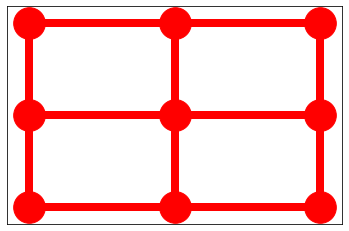

In [208]:
connections=next(R)
print(next(E))
#fig=plt.figure(figsize=(25, 25))
for i in range(l):
    if connections[f'y{i}']==1:
        rout_edges.append(list(labels.keys())[i])
nx.draw_networkx_nodes(G,pos,node_size=1000,node_color='r')
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_edges(
    G, pos, edgelist=rout_edges, width=8, edge_color='r'
)  
plt.show()

In [209]:
#hybrid solution
import hybrid

# Construct a problem
offset=0.0
vartype = dimod.BINARY
bqm = dimod.BinaryQuadraticModel(H, J, offset, vartype)

# Define the workflow
iteration = hybrid.RacingBranches(
    hybrid.InterruptableTabuSampler(),
    hybrid.EnergyImpactDecomposer(size=2)
    | hybrid.QPUSubproblemAutoEmbeddingSampler()
    | hybrid.SplatComposer()
) | hybrid.ArgMin()
workflow = hybrid.LoopUntilNoImprovement(iteration, convergence=3)

# Solve the problem
init_state = hybrid.State.from_problem(bqm)
final_state = workflow.run(init_state).result()

# Print results
print("Solution: sample={.samples.first}".format(final_state))

Solution: sample=Sample(sample={'w05': 0, 'w26': 0, 'w27': 0, 'w48': 0, 'w67': 0, 'y0': 1, 'y1': 1, 'y10': 1, 'y11': 1, 'y2': 1, 'y3': 1, 'y4': 1, 'y5': 1, 'y6': 1, 'y7': 1, 'y8': 1, 'y9': 1}, energy=-32.0, num_occurrences=1)


In [210]:
R=iter(final_state.samples)
rout_edges=[]


/home/sarashs/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


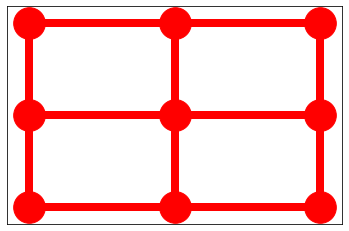

In [211]:
connections=next(R)
for i in range(l):
    if connections[f'y{i}']==1:
        rout_edges.append(list(labels.keys())[i])
nx.draw_networkx_nodes(G,pos,node_size=1000,node_color='r')
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_edges(
    G, pos, edgelist=rout_edges, width=8, edge_color='r'
)  
plt.show()